# Identify AR Events Gridded

In [1]:
%matplotlib ipympl

In [2]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature 

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54668,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54688,Total threads: 3
Dashboard: http://127.0.0.1:54692/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54671,


Load data from from Zarr store.

In [4]:
zarr_store = 'gs://cesm2/ivt.zarr'
ds_full = xr.open_zarr(zarr_store, consolidated=False)#, chunks={"time":-1, "lat":"auto", "lon":"auto"})
print(f'Variable size: {ds_full.nbytes/1e9:.1f} GB')

Variable size: 40.5 GB


Select a set of grid cells that cover Bodega Bay, CA (38.3332° N, 123.0481° W)

In [5]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
cell_buffer = 10

# the nearest index for the lat/lon provided above
ilon = list(ds_full.lon.values).index(ds_full.sel(lon=lon, method='nearest').lon)
ilat = list(ds_full.lat.values).index(ds_full.sel(lat=lat, method='nearest').lat)

# subset these data to include cells above and below this lat/lon
ds = ds_full.isel(lat=range(ilat-cell_buffer, ilat+cell_buffer),
                  lon=range(ilon-cell_buffer, ilon+cell_buffer)).IVT
ds = ds.to_dataset()

Plot the IVT data for these cells at `time=0` to visualize our domain.

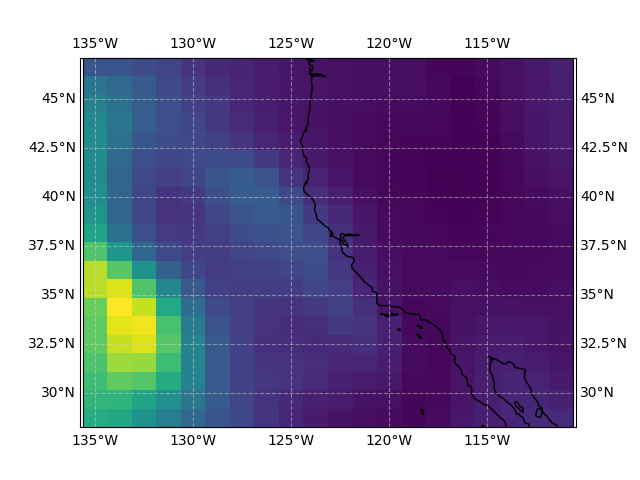

In [6]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).IVT.plot(label='',
                         add_labels=False,
                         add_colorbar=False,
                         xticks=None,
                         yticks=None)
plt.show()

## Identify AR Events

In [ ]:
# convert the time index to datetime64. This is needed to compute probabilities.
ds['time'] = ds.time.values.astype('datetime64[ns]')  

Assign an index to each group of timesteps that meet AR conditions

In [ ]:
ds['AR_INDEX'] = xr.apply_ufunc(
    ARUtils.identify_ar_events,  
    ds.IVT,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the duration for each AR event

In [ ]:
ds['AR_DURATION'] = xr.apply_ufunc(
    ARUtils.compute_ar_durations,  
    ds.AR_INDEX,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the category (1-5) for each AR event

In [ ]:
ds['AR_CATEGORY'] = xr.apply_ufunc(
    ARUtils.compute_ar_category,  
    ds.AR_INDEX,
    ds.AR_DURATION,
    ds.IVT,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the probability of each AR event occurring.

In [ ]:
res = xr.apply_ufunc(
    ARUtils.compute_ar_probability,
    ds.AR_INDEX,
    ds.AR_CATEGORY,
    input_core_dims=[["time"],["time"]],
    output_core_dims=[['category']],
    # output_sizes={'category': 5},
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True,
                        'output_sizes': {'category': 5}},
)

# Add the category dimension (from 1 to 5)
res = res.assign_coords(category=np.arange(1, 6))

# add the newly computed probabilty back to the original dataset
ds = ds.assign(AR_PROBABILITY=res)

Compute the magnitude of each AR event.

In [ ]:
ds['AR_DEGREE'] = xr.apply_ufunc(
    ARUtils.compute_ar_degree,
    ds.IVT,
    ds.AR_DURATION,
    ds.AR_INDEX,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[['time']],
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

## Plot Computed AR Categories and Degrees

Plot the degree of Category 5 Atmospheric Rivers

In [ ]:
# create a plot to test
lat = 38.
lon = -123.125 + 360 
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest')

# plot AR_DEGREE for cat 5 events
ds_cat5 = ds_cell.where(ds_cell['AR_CATEGORY'] == 5, drop=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].scatter(x=ds_cat5.time, y=ds_cat5.AR_DEGREE)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('AR Degree')

axes[1].scatter(x=ds_cat5.AR_INDEX, y=ds_cat5.AR_DEGREE)
axes[1].set_xlabel('AR Index')
axes[1].set_ylabel('AR Degree')


plt.tight_layout()
plt.show()

Spatially plot the probability of Category 5 Atmospheric Rivers

In [ ]:
fig, ax = plt.subplots()

ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.AR_PROBABILITY.sel(category=5).plot()
#ds.AR_PROBABILITY.sel(category=5).plot.contour()

plt.title('AR Category 5 Probability')
plt.show()



Plot Atmospheric Rivers category at a singe point in time.

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).AR_CATEGORY.plot(label='',
                                 add_labels=False,
                                 add_colorbar=True,
                                 xticks=None,
                                 yticks=None,
                                 cbar_kwargs={"location": "bottom", "pad":0.1})

plt.title('AR Category at t=0')
plt.show()

Mean Atmospheric Rivers category through the record of data.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))
#ax[0].axis('off')
#ax[1].axis('off')

ax[0].coastlines();
ax[1].coastlines();

#add lat lon grids
ax[0].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
ax[1].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');


ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot(label='',
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[0])

ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot.contour(
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[1])

fig.suptitle('Mean AR Category: 1980-1989')
plt.tight_layout()
plt.show()

Sum of Atmospheric Rivers category through the record of data.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))

ax[0].coastlines();
ax[1].coastlines();

#add lat lon grids
ax[0].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
ax[1].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');


(ds.where(ds.AR_CATEGORY == 5).AR_CATEGORY.sum(dim='time') / 5).plot(label='',
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[0])
(ds.where(ds.AR_CATEGORY == 5).AR_CATEGORY.sum(dim='time') / 5).plot.contour(
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[1])

fig.suptitle('Sum AR Category: 1980-1989')
plt.tight_layout()
plt.show()